# Detecting lung cancer biomarkers using RF classifier

## Overview
Download lung cancer dataset from public database(s), then build a random forest (RF) classifier using the python scikit learn package that diagnoses lung cancer using gene expression data

## Step 1. Download gene expression data from GEO
In Step 1, we are acting as "data scavengers." We are reaching out to the National Center for Biotechnology Information (NCBI) servers to pull a specific experimental record into your local Python environment.

What is the "GSE" record?

When a scientist publishes a paper (e.g., "Gene changes in Lung Cancer"), they are required to upload their data to the Gene Expression Omnibus (GEO). They organize this into a GSE (Series) record.

Think of a GSE as a digital "experiment folder." When you run GEOparse.get_GEO(geo="GSE12345"), you are downloading that entire folder, which typically contains three main components:

|Component|GEO Name|Meaning|
|---------|--------|-------|
|Measurements|GSM|Expression value of every gene|
|Sample description|Metadata|e.g. Sample 1 is Female|
|Dictionary|GPL|A map of probe IDs and meaning e.g. 200008_s is BRCA1|

In [1]:
import GEOparse

# --- Download the Lung Cancer dataset ---
gse = GEOparse.get_GEO(geo="GSE19804", destdir="./")


01-Jan-2026 19:27:20 DEBUG utils - Directory ./ already exists. Skipping.
01-Jan-2026 19:27:20 INFO GEOparse - File already exist: using local version.
01-Jan-2026 19:27:20 INFO GEOparse - Parsing ./GSE19804_family.soft.gz: 
01-Jan-2026 19:27:20 DEBUG GEOparse - DATABASE: GeoMiame
01-Jan-2026 19:27:20 DEBUG GEOparse - SERIES: GSE19804
01-Jan-2026 19:27:20 DEBUG GEOparse - PLATFORM: GPL570
/opt/anaconda3/envs/bioinfor-to-ai-env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
01-Jan-2026 19:27:22 DEBUG GEOparse - SAMPLE: GSM494556
01-Jan-2026 19:27:22 DEBUG GEOparse - SAMPLE: GSM494557
01-Jan-2026 19:27:22 DEBUG GEOparse - SAMPLE: GSM494558
01-Jan-2026 19:27:22 DEBUG GEOparse - SAMPLE: GSM494559
01-Jan-2026 19:27:22 DEBUG GEOparse - SAMPLE: GSM494560
01-Jan-2026 19:27:22 DEBUG GEOparse - SAMPLE: GSM494561
01-Jan-2026 19:27:

## Step 2. Extract gene expression (X) and labels (y) from downloaded labels
We will parse data using Geoparser too. Recommend reading [GEOparser official documentaion](https://geoparse.readthedocs.io/en/latest/index.html) to understand the objects used by Geoparser.

In [2]:
# --- Extract Labels ---
# Get metadata to find our groups (e.g., 'treatment' vs 'control')
metadata = gse.phenotype_data

# Identify the labels for classification in metadata
labels = metadata['characteristics_ch1.0.tissue']

labels.value_counts()  # Check the distribution of labels

characteristics_ch1.0.tissue
lung cancer               60
paired normal adjacent    60
Name: count, dtype: int64

In [3]:
# --- Extract gene expression matrix (genes as rows, samples as columns) ---
data = gse.pivot_samples('VALUE')

# log-transform the gene expression data
import numpy as np
data = np.log2(data + 1)

data.shape # Check the shape of the expression matrix

(54675, 120)

## Step 3. Build and train a classifier using Random Forest

In [4]:
# --- Extract gene expression matrix (genes as rows, samples as columns) ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# --- Preprocessing ---
# Transpose so samples are rows and genes are columns
X = data.T 
y = labels

# --- Step 4: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Step 5: Build and Train the Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- Step 6: Evaluate ---
predictions = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

Accuracy: 0.9722222222222222
                        precision    recall  f1-score   support

           lung cancer       1.00      0.95      0.97        19
paired normal adjacent       0.94      1.00      0.97        17

              accuracy                           0.97        36
             macro avg       0.97      0.97      0.97        36
          weighted avg       0.97      0.97      0.97        36



In biology, we rarely care just about the "accuracy." We want to know which genes drive the difference. Models in scikit learn provides a feature_importances_ attribute that ranks every gene:

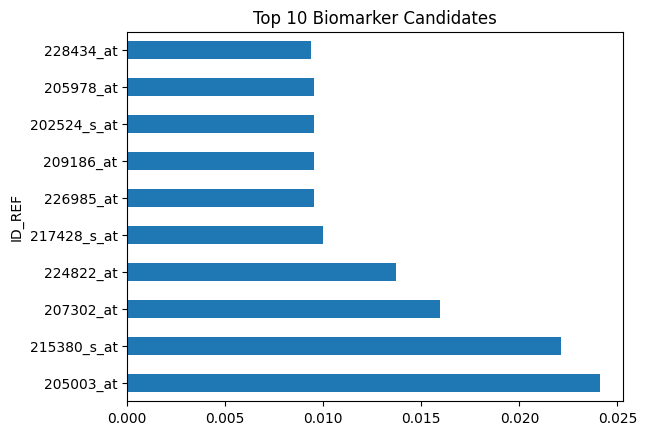

In [5]:
# Extract and plot the top 10 most important genes
from matplotlib import pyplot as plt
import pandas as pd


importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Biomarker Candidates")
plt.show()

Retrieving gene information from GPL table:

In [6]:
# 1. Get the Platform (GPL) table
gpl = list(gse.gpls.values())[0]

gpl_table = gpl.table
# display information of 10 top genes
gpl_table.loc[gpl_table['ID'].isin(importances.nlargest(10).index), ['ID', 'Gene Title', 'Gene Symbol']]



,ID,Gene Title,Gene Symbol
11972,202524_s_at,"sparc/osteonectin, cwcv and kazal-like domains...",SPOCK2
14450,205003_at,dedicator of cytokinesis 4,DOCK4
15425,205978_at,klotho,KL
16746,207302_at,"sarcoglycan, gamma (35kDa dystrophin-associate...",SGCG
18600,209186_at,"ATPase, Ca++ transporting, cardiac muscle, slo...",ATP2A2
24674,215380_s_at,gamma-glutamylcyclotransferase,GGCT
26713,217428_s_at,"collagen, type X, alpha 1",COL10A1
34080,224822_at,DLC1 Rho GTPase activating protein,DLC1
36240,226985_at,"FYVE, RhoGEF and PH domain containing 5",FGD5
37688,228434_at,butyrophilin-like 9,BTNL9
